<h2>TAXI FARE DATSET</h2>

----

The data set contains around 3,000 records. The feature details are as follows.

<br>

- index : a random row id of the record
- unique_id : unique row identifier
- amount : total fare of the trip
- pkptime : pickup time
- pkp_long : longitude of the pickup location
- pkp_lat : latitude of the pickup location
- drp_long : longitude of the drop location
- drp_lat : latitude of the drop location
- pass : number of passengers


In [77]:
# IMPORTING LIBRARIES :
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
from math import radians,sin,asin,cos,sqrt

from shapely.geometry import Point
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import pylab
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import statsmodels.api as sts
import scipy.stats as sci_sts
from scipy.stats import normaltest
import statsmodels.stats.api as ssa
from sklearn.feature_selection import f_classif

from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering as agc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOADING THE DATASET :
df=pd.read_csv('Regression - taxi fare.csv')

display(df.info())
print('\n\n')
display(df.head().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      3000 non-null   int64  
 1   unique_id  3000 non-null   object 
 2   amount     3000 non-null   float64
 3   pkptime    3000 non-null   object 
 4   pkp_long   3000 non-null   float64
 5   pkp_lat    3000 non-null   float64
 6   drp_long   3000 non-null   float64
 7   drp_lat    3000 non-null   float64
 8   pass       3000 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 211.1+ KB


None

,0,1,2,3,4
index,10,17,38,52,60
unique_id,30:50.0,08:00.0,42:00.0,01:38.0,57:00.0
amount,5.3,5.3,9.0,8.0,5.0
pkptime,2012-04-08 07:30:50 UTC,2009-07-22 16:08:00 UTC,2013-11-24 11:42:00 UTC,2013-01-23 07:01:38 UTC,2014-07-16 10:57:00 UTC
pkp_long,-73.996335,-73.98106,-73.95774,-73.980298,-73.996148
pkp_lat,40.737142,40.73769,40.773617,40.783723,40.74189
drp_long,-73.980721,-73.994177,-73.977087,-73.979628,-73.992202
drp_lat,40.733559,40.728412,40.758465,40.763179,40.739425
pass,1,1,6,1,6


- Target column is 'amount'

In [55]:
target='amount'

## EDA

In [104]:
# Function to plot columns
def plot_column(data,col,bins=5,figsize=(15,4),type=['count','hist']) :
    fig=plt.figure(figsize=figsize)
    fig.add_subplot(1,2,1)
    plt.boxplot(data[col],vert=False,whis=2,showmeans=True)
    plt.title('Boxplot')

    fig.add_subplot(1,2,2)
    if type=='hist' :
      n,bins,_=plt.hist(data[col],bins=bins,edgecolor='black',color='lightblue')
      plt.xticks(ticks=bins)
      plt.title('Histogram')

    elif type=='count':
      sns.countplot(data=data,x=col)
      plt.title('Countplot')

    fig.suptitle('Variable : %s' %col)
    plt.show()

#### Longitude and Latitude :

In [23]:
# Function to plot longitude and latitude from dataset
def plot_coord(data,long,lat,on_map,clusters=None,colours='red',title=None,figsize=(10,8)) :
    co_ordinates=list(zip(data[long],data[lat]))
    geometry= [Point(c) for c in co_ordinates]
    geo_df=gpd.GeoDataFrame(data,geometry=geometry)


    if clusters==None :
        ax1=on_map.plot(color='lightblue',figsize=figsize)
        geo_df.plot(ax=ax1,color=colours)
        plt.title(title)
        plt.axis('off')

    elif clusters!=None :
        ax1=on_map.plot(color='lightblue',figsize=figsize)
        for c in np.sort(data[clusters].unique()) :
            geo_df[geo_df[clusters]==c].plot(ax=ax1,color=colours[c],label='C'+str(c))
        plt.title(title)
        plt.legend(bbox_to_anchor=(1.025,1),title='Clusters')
        plt.axis('off')
    plt.show()

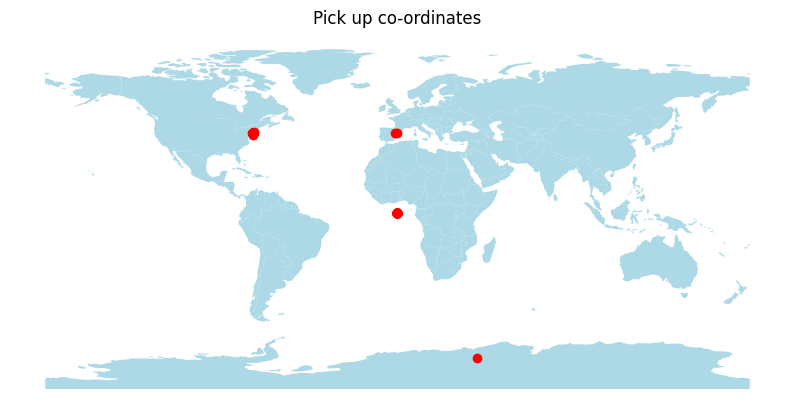

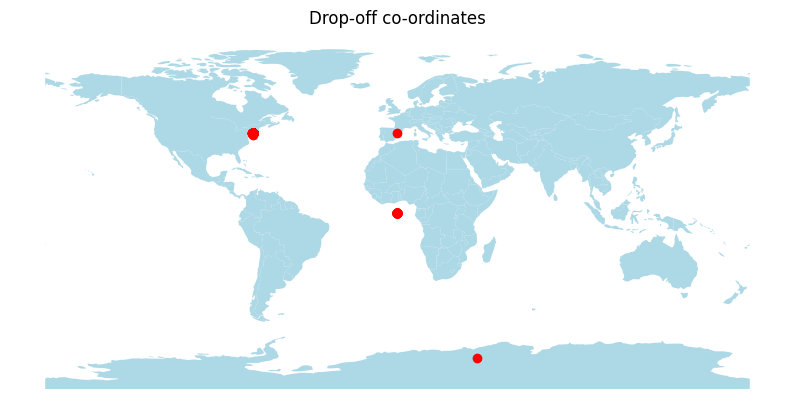

In [19]:
# Geographic columns :
    # Plotting the coordinates on a world map
countries=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

plot_coord(df,long='pkp_long',lat='pkp_lat',on_map=countries,title='Pick up co-ordinates')
plot_coord(df,long='drp_long',lat='drp_lat',on_map=countries,title='Drop-off co-ordinates')

- Coordinates where longitude and latitude do not mark on land but in the ocean and on Antarctica are most likely to be either half missing, incorrect or faulty entries.
- Cluster coordinates and then remove incorrect records.

In [20]:
# Clustering pick_up and drop_off geo locations into 4 clusters each using Hierarchical clustering algorithm
df1=df.copy()
colours=['red','green','indigo','magenta']

pick_up=df1[['pkp_lat','pkp_long']]
drop_off=df1[['drp_lat','drp_long']]

0    2930
3      67
1       2
2       1
Name: pick_up_point, dtype: int64 




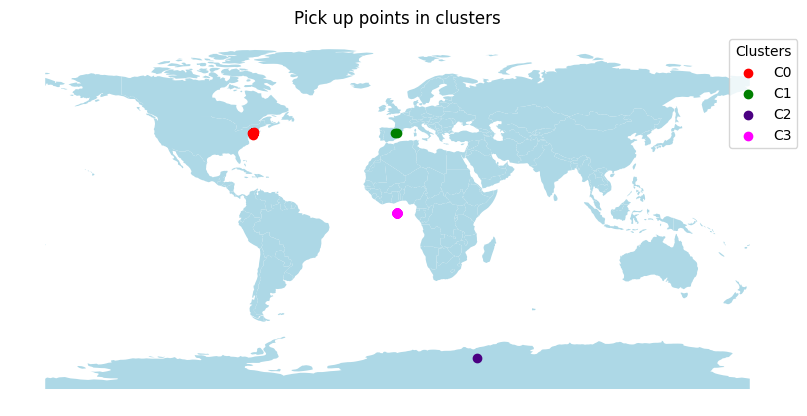

In [24]:
# Clusters of pick up points
pickup_clusters=agc(n_clusters=4).fit_predict(pick_up)
df1['pick_up_point']=pickup_clusters

print(df1['pick_up_point'].value_counts(),'\n\n')
plot_coord(df1,lat='pkp_lat',long='pkp_long',clusters='pick_up_point',colours=colours,title='Pick up points in clusters',on_map=countries)

0    2930
1      68
2       1
3       1
Name: drop_off_point, dtype: int64 




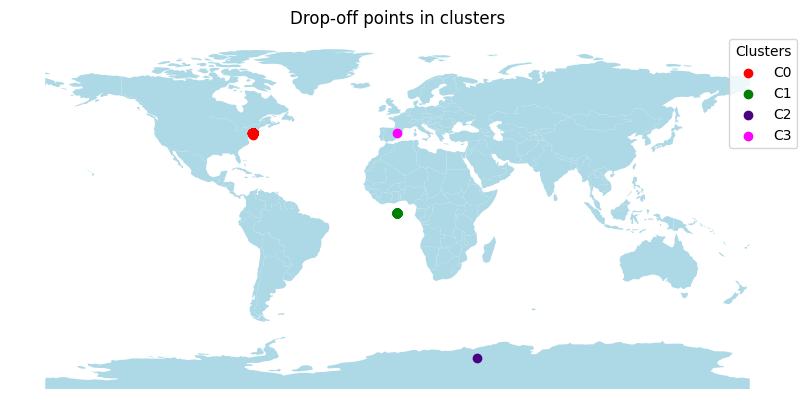

In [26]:
# Clusters of drop off points
dropoff_clusters=agc(n_clusters=4).fit_predict(drop_off)
df1['drop_off_point']=dropoff_clusters

print(df1['drop_off_point'].value_counts(),'\n\n')
plot_coord(df1,lat='drp_lat',long='drp_long',clusters='drop_off_point',colours=colours,title='Drop-off points in clusters',on_map=countries)

In [38]:
# Indices of records which belong to clusters with incorect co-ordinates, ie. all records not in cluster 0
pkp_idx=df1[df1['pick_up_point']!=0].index
drp_idx=df1[df1['drop_off_point']!=0].index

print('Incorrect pick up co-ordinates :')
display(df1.iloc[pkp_idx,:])

print('\n\nIncorrect drop off co-ordinates :')
display(df1.iloc[drp_idx,:])

print('\n\nAre both the arrays equal ?', np.array_equal(pkp_idx,drp_idx))

Incorrect pick up co-ordinates :


,index,unique_id,amount,pkptime,pkp_long,pkp_lat,drp_long,drp_lat,pass,pick_up_point,drop_off_point
40,542,23:00.0,4.5,2009-12-29 14:23:00 UTC,0.0,0.0,0.000000,0.000000,1,3,1
110,1637,52:56.0,8.5,2015-04-06 18:52:56 UTC,0.0,0.0,0.000000,0.000000,1,3,1
117,1704,15:00.0,6.1,2011-02-05 22:15:00 UTC,0.0,0.0,0.000000,0.000000,5,3,1
218,3357,40:00.0,6.0,2013-02-15 01:40:00 UTC,0.0,0.0,0.000000,0.000000,1,3,1
251,3908,43:29.0,4.5,2014-06-11 07:43:29 UTC,0.0,0.0,0.000000,0.000000,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
2785,46534,58:06.0,5.3,2011-04-19 18:58:06 UTC,0.0,0.0,0.000000,0.000000,2,3,1
2824,47045,29:47.0,10.0,2014-01-28 16:29:47 UTC,0.0,0.0,-73.969268,40.764555,1,3,0
2898,48443,19:00.0,11.3,2009-02-28 16:19:00 UTC,0.0,0.0,0.000000,0.000000,2,3,1
2927,48836,12:55.0,4.5,2011-11-02 22:12:55 UTC,0.0,0.0,0.000000,0.000000,1,3,1




Incorrect drop off co-ordinates :


,index,unique_id,amount,pkptime,pkp_long,pkp_lat,drp_long,drp_lat,pass,pick_up_point,drop_off_point
40,542,23:00.0,4.5,2009-12-29 14:23:00 UTC,0.0,0.0,0.0,0.0,1,3,1
110,1637,52:56.0,8.5,2015-04-06 18:52:56 UTC,0.0,0.0,0.0,0.0,1,3,1
117,1704,15:00.0,6.1,2011-02-05 22:15:00 UTC,0.0,0.0,0.0,0.0,5,3,1
218,3357,40:00.0,6.0,2013-02-15 01:40:00 UTC,0.0,0.0,0.0,0.0,1,3,1
251,3908,43:29.0,4.5,2014-06-11 07:43:29 UTC,0.0,0.0,0.0,0.0,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
2770,46223,30:00.0,8.1,2009-10-02 08:30:00 UTC,0.0,0.0,0.0,0.0,1,3,1
2785,46534,58:06.0,5.3,2011-04-19 18:58:06 UTC,0.0,0.0,0.0,0.0,2,3,1
2898,48443,19:00.0,11.3,2009-02-28 16:19:00 UTC,0.0,0.0,0.0,0.0,2,3,1
2927,48836,12:55.0,4.5,2011-11-02 22:12:55 UTC,0.0,0.0,0.0,0.0,1,3,1




Are both the arrays equal ? False


In [39]:
pkp_idx == drp_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True])

In [40]:
# unique indices from both the arrays
idx_to_drop=np.union1d(pkp_idx,drp_idx)

In [41]:
# Droping these records
df1.drop(idx_to_drop,axis=0,inplace=True)
df1.reset_index(drop=True,inplace=True)

#### Distance travelled :

In [44]:
# Calculating the distance (in kilometers) between pickup points and dropoff points
r=6371       # Radius of Earth in KM
distances=[]

for i in range(0,len(df1),1) :
    long1=radians(df1['pkp_long'][i])
    long2=radians(df1['drp_long'][i])

    lat1=radians(df1['pkp_lat'][i])
    lat2=radians(df1['drp_lat'][i])

    # Haversine formula
    long_dist=long2-long1
    lat_dist=lat2-lat1

    a=sin(lat_dist/2)**2 + cos(lat1)*cos(lat2)*(sin(long_dist/2))**2
    c=2*asin(sqrt(a))
    distances.append(c*r)

# Creating distance travelled column
df1['distance']=distances

display(df1.head())
print('\n',df1['distance'].describe())

,index,unique_id,amount,pkptime,pkp_long,pkp_lat,drp_long,drp_lat,pass,pick_up_point,drop_off_point,distance
0,10,30:50.0,5.3,2012-04-08 07:30:50 UTC,-73.996335,40.737142,-73.980721,40.733559,1,0,0,1.374577
1,17,08:00.0,5.3,2009-07-22 16:08:00 UTC,-73.981060,40.737690,-73.994177,40.728412,1,0,0,1.511904
2,38,42:00.0,9.0,2013-11-24 11:42:00 UTC,-73.957740,40.773617,-73.977087,40.758465,6,0,0,2.343802
3,52,01:38.0,8.0,2013-01-23 07:01:38 UTC,-73.980298,40.783723,-73.979628,40.763179,1,0,0,2.285085
4,60,57:00.0,5.0,2014-07-16 10:57:00 UTC,-73.996148,40.741890,-73.992202,40.739425,6,0,0,0.430871


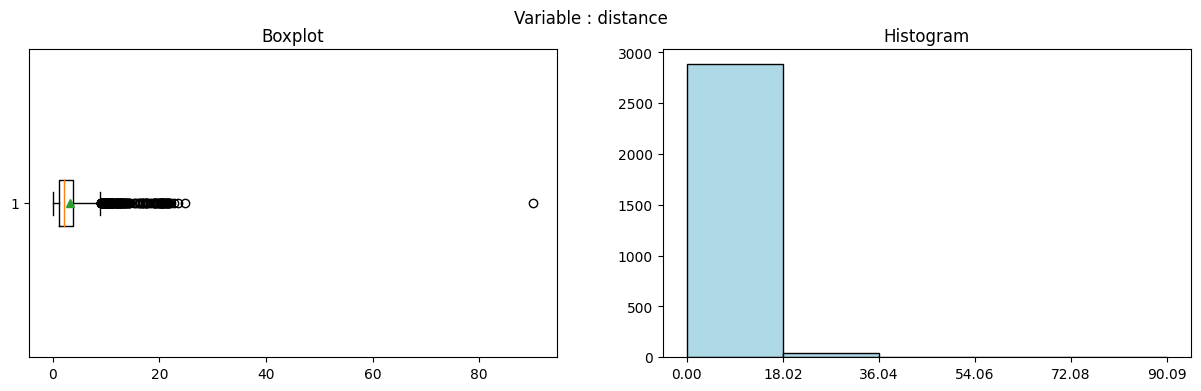

In [53]:
# Boxplot of distance column
plot_column(df1,col='distance',bins=5)

In [57]:
# Index of maximum distance travelled
dist_idx=np.where(df1['distance']==df1['distance'].max())

dist_idx

(array([1351]),)

- Remove the record with the maximum distance.
- Drop the columns 'pkp_long','pkp_lat','drp_long','drp_lat' and 'geometry'
- Remove the 'pick_up_point' and 'drop_off_point' columns as well.

In [60]:
cols_to_drop=['pkp_long','pkp_lat','drp_long','drp_lat','pick_up_point','drop_off_point']

# Drop record with max distance
df1.drop(dist_idx[0],axis=0,inplace=True)

# Drop unrequired columns
df1.drop(cols_to_drop,axis=1,inplace=True)

# reset index
df1.reset_index(drop=True,inplace=True)

#### Unique id and pkptime :

In [61]:
# Unique ID and Pick up time columns :
display(df1[['unique_id','pkptime']])

,unique_id,pkptime
0,30:50.0,2012-04-08 07:30:50 UTC
1,08:00.0,2009-07-22 16:08:00 UTC
2,42:00.0,2013-11-24 11:42:00 UTC
3,01:38.0,2013-01-23 07:01:38 UTC
4,57:00.0,2014-07-16 10:57:00 UTC
...,...,...
2921,59:00.0,2012-10-05 20:59:00 UTC
2922,36:00.0,2013-06-23 19:36:00 UTC
2923,46:12.0,2015-04-16 01:46:12 UTC
2924,55:00.0,2010-08-25 20:55:00 UTC


In [66]:
# Verifying if 'unique_id' is a subset of 'pkptime' column
x={'True':[],'False':[]}
c1,c2=0,0

for i in range(0,len(df1),1) :
    df1['unique_id'][i]=df1['unique_id'][i][:-2]    # trimming the string
    if (df1['unique_id'][i] in df1['pkptime'][i])==True :
        c1+=1
        x['True']=c1
    else :
        c2+=1
        x['False']=c2

print('# of records where unique_id and pkptime are same :',x)
print('Total number of records in the dataset : ',len(df1))

# of records where unique_id and pkptime are same : {'True': 2926, 'False': []}
Total number of records in the dataset :  2926


- All records show that 'unique_id' is a subset of 'pkptime' column
- Since both columns represent datetime data type, convert 'pkptime' to datetime column
- Drop 'unique_id' column
- Create new columns from 'pkptime' column

In [111]:
# Converting dtype of 'pkptime' into datetime
df1['pkptime']=pd.to_datetime(df1['pkptime'])

# Creating new columns
df1['pkp_year']=df1['pkptime'].dt.year
df1['pkp_month']=df1['pkptime'].dt.month
df1['pkp_weekday']=df1['pkptime'].dt.strftime('%A')
df1['pkp_weekday']=pd.Categorical(df1['pkp_weekday'],categories=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],ordered=True)
df1['pkp_day']=df1['pkptime'].dt.day
df1['pkp_hour']=df1['pkptime'].dt.hour
df1['pkp_minute']=df1['pkptime'].dt.minute

display(df1.head())

,index,unique_id,amount,pkptime,pass,distance,pkp_year,pkp_month,pkp_weekday,pkp_day,pkp_hour,pkp_minute
0,10,,5.3,2012-04-08 07:30:50+00:00,1,1.374577,2012,4,Sunday,8,7,30
1,17,,5.3,2009-07-22 16:08:00+00:00,1,1.511904,2009,7,Wednesday,22,16,8
2,38,,9.0,2013-11-24 11:42:00+00:00,6,2.343802,2013,11,Sunday,24,11,42
3,52,,8.0,2013-01-23 07:01:38+00:00,1,2.285085,2013,1,Wednesday,23,7,1
4,60,,5.0,2014-07-16 10:57:00+00:00,6,0.430871,2014,7,Wednesday,16,10,57


In [118]:
# 5 point description of target variable for different years
years={}

for i in np.sort(df1['pkp_year'].unique()) :
    z=df1[df1['pkp_year']==i][target].describe()
    z['lower limit']=round(z['25%']-1.5*(z['75%']-z['25%']),2)
    z['upper limit']=round(z['25%']+1.5*(z['75%']-z['25%']),2)
    years[i]=z

display(pd.concat(years,axis=1))

,2009,2010,2011,2012,2013,2014,2015
count,463.000000,448.000000,458.000000,487.000000,445.000000,425.000000,200.000000
mean,9.607667,9.733772,10.473581,10.851540,12.167191,13.178282,13.995050
std,6.347675,7.124835,9.284359,8.755043,9.487680,11.255561,12.442003
min,2.500000,2.500000,2.500000,2.500000,-3.000000,2.500000,2.500000
25%,5.700000,5.700000,5.700000,6.000000,6.500000,6.500000,7.375000
50%,7.700000,7.700000,7.700000,8.500000,9.500000,10.000000,9.500000
75%,11.300000,10.900000,11.600000,11.700000,14.500000,15.000000,14.500000
max,50.000000,51.700000,85.000000,75.000000,57.330000,110.000000,76.750000
lower limit,-2.700000,-2.100000,-3.150000,-2.550000,-5.500000,-6.250000,-3.310000
upper limit,14.100000,13.500000,14.550000,14.550000,18.500000,19.250000,18.060000


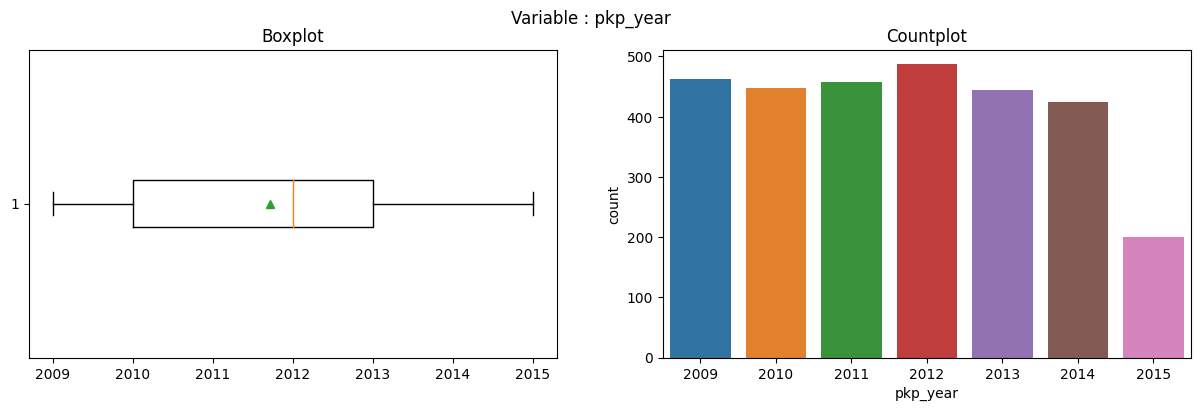

In [80]:
# pkp_year column :
plot_column(df1,col='pkp_year',type='count')

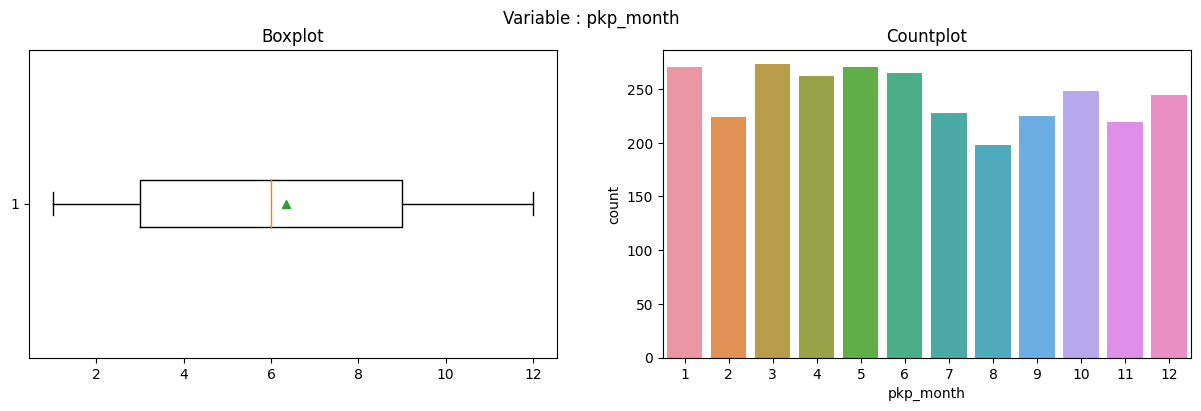

In [114]:
# pkp_month column :
plot_column(df1,col='pkp_month',type='count')

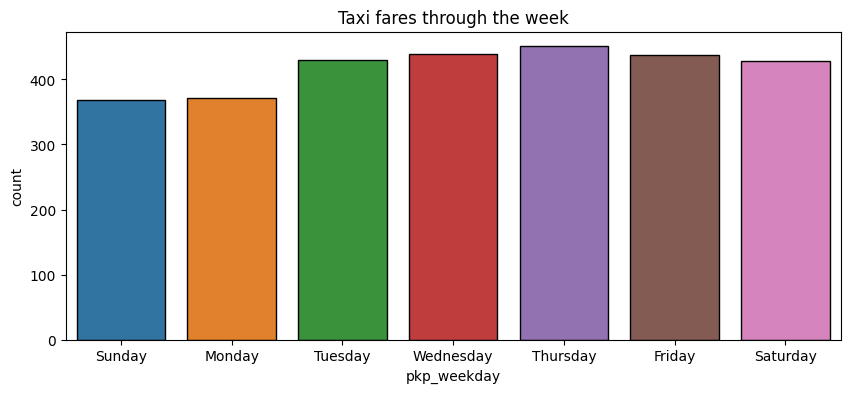

In [115]:
# pkp_weekday column :
plt.figure(figsize=(10,4))
sns.countplot(df1,x='pkp_weekday',edgecolor='black')
plt.title('Taxi fares through the week')
plt.show()

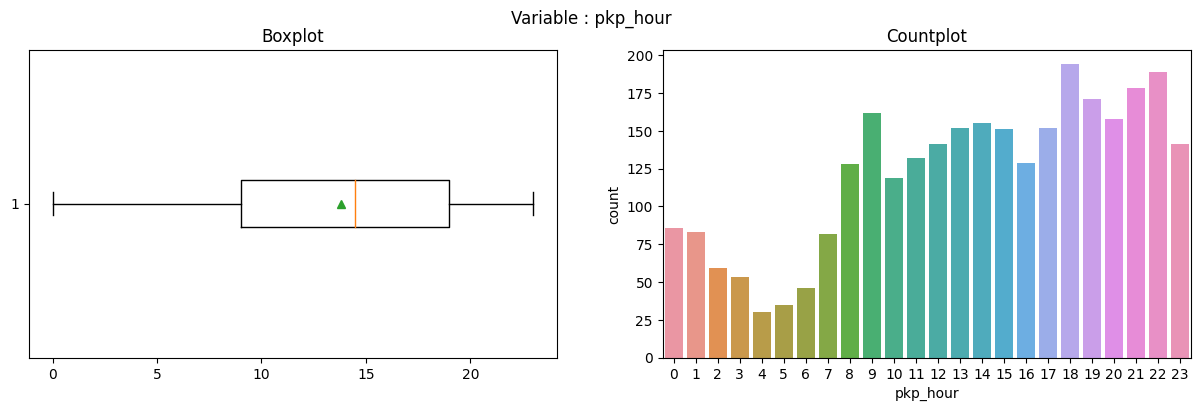

In [97]:
# pkp_hour column :
plot_column(df1,col='pkp_hour',type='count')

#### Pass :

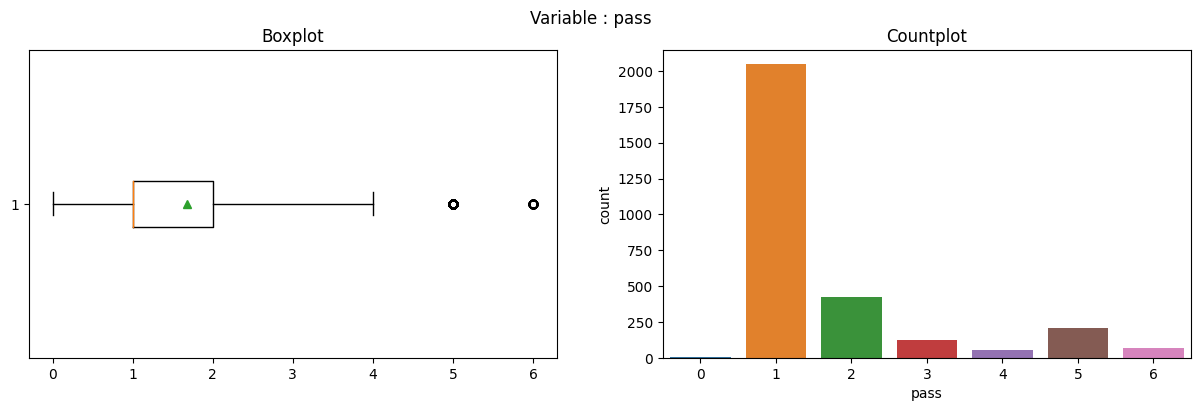



Percentage of passengers in a trip :
 1    0.70
2    0.14
5    0.07
3    0.04
6    0.02
4    0.02
0    0.00
Name: pass, dtype: float64


In [125]:
# Passenger column :
plot_column(df1,col='pass',type='count')

print('\n\nPercentage of passengers in a trip :\n',round(df1['pass'].value_counts()/len(df1),2))

In [126]:
# Trips with 0 passengers
display(df1[['amount','distance']][df1['pass']==0])

,amount,distance
40,4.9,1.020108
526,2.5,0.000000
775,10.9,2.941795
952,12.9,4.456814
1395,8.5,1.814951
1661,8.9,2.919326
1812,17.3,7.776576
2564,7.7,1.268244


In [127]:
# Drop the records where no. of passengers is 0
idx=np.where(df1['pass']==0)[0]

df1.drop(idx,axis=0,inplace=True)
df1.reset_index(drop=True,inplace=True)

#### Amount :

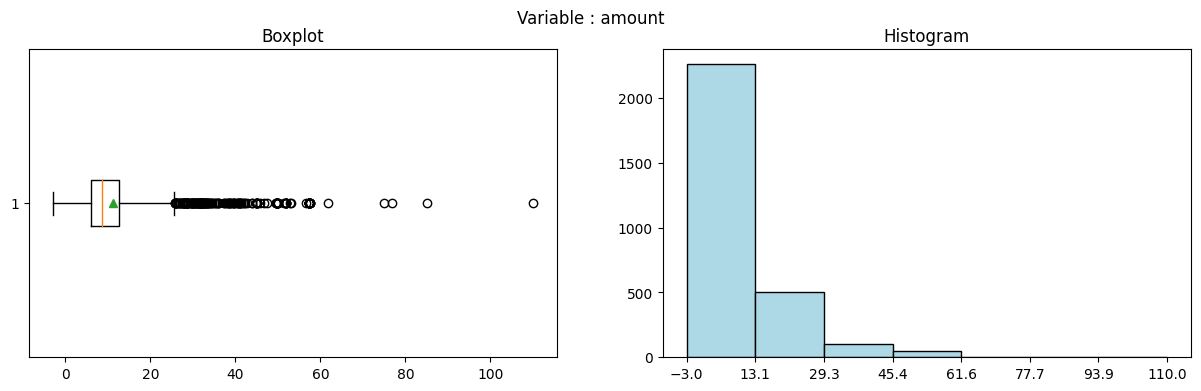



 count    2918.000000
mean       11.182748
std         9.226869
min        -3.000000
25%         6.000000
50%         8.500000
75%        12.500000
max       110.000000
Name: amount, dtype: float64


In [129]:
# Target variable 'amount' :
plot_column(df1,target,type='hist',bins=7)

print('\n\n',df1[target].describe())

- There are outliers in the target variable.
- Filter out records where amount is negative and distance travelled is more than 60kms.

In [130]:
# Filtering
target_idx=df1[[target,'distance']][(df1[target]>60) | (df1[target]<0)]

print(target_idx)

      amount   distance
758    -3.00   0.096377
1061   85.00   0.000000
1101   75.00  17.479290
1171   76.75  15.453662
1523  110.00   0.003638
2506   61.80  15.356748


In [131]:
# Droping the records where target value has higher outliers values
df1.drop(target_idx.index,axis=0,inplace=True)

df1.reset_index(drop=True,inplace=True)

## Preprocessing :

In [133]:
# Datatypes in dataset
print(df1.dtypes)

# only numeric data
num=df1.drop(target,axis=1).select_dtypes(include=['int','float']).columns.values

index                        int64
unique_id                   object
amount                     float64
pkptime        datetime64[ns, UTC]
pass                         int64
distance                   float64
pkp_year                     int64
pkp_month                    int64
pkp_weekday               category
pkp_day                      int64
pkp_hour                     int64
pkp_minute                   int64
dtype: object


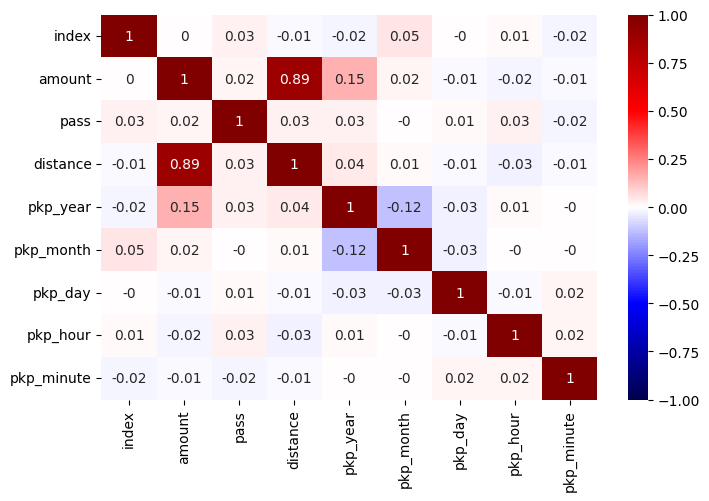

In [138]:
# CORRELATION :
def corr_df(data) :
    plt.figure(figsize=(8,5))
    sns.heatmap(round(data.corr(),2),cmap='seismic',vmin=-1,vmax=1,annot=True)
    plt.show()

corr_df(df1)

In [139]:
# FEATURE SELECTION :
def best_features(data,target) :
    feature_scores,pval=f_classif(data, target)
    df_features=pd.DataFrame({'feature_name':data.columns.values,
                              'scores':feature_scores,
                              'p_values' :pval}).sort_values('scores',ascending=False)
    print(df_features)
    return df_features

df_features=best_features(df1[num],target=df1[target])

  feature_name     scores  p_values
2     distance  74.451617  0.000000
3     pkp_year  16.352371  0.000000
6     pkp_hour   1.309611  0.002241
4    pkp_month   1.039492  0.337548
7   pkp_minute   1.003336  0.475409
5      pkp_day   0.995722  0.505896
1         pass   0.964046  0.632101
0        index   0.890260  0.868562


In [141]:
# SCALING THE DATASET :
scaler=preprocessing.StandardScaler()

# Dataframe to use in model building
df_scaled=pd.DataFrame(scaler.fit_transform(df1[num]), columns=num)
df_scaled[target]=df1[target]

display(df_scaled.head())

,index,pass,distance,pkp_year,pkp_month,pkp_day,pkp_hour,pkp_minute,amount
0,-1.719354,-0.518855,-0.543788,0.156222,-0.676658,-0.871030,-1.07081,0.018781,5.3
1,-1.718869,-0.518855,-0.503499,-1.455060,0.190608,0.741529,0.34498,-1.255776,5.3
2,-1.717414,3.312039,-0.259436,0.693316,1.346963,0.971894,-0.44157,0.713994,9.0
3,-1.716443,-0.518855,-0.276662,0.693316,-1.543925,0.856712,-1.07081,-1.661316,8.0
4,-1.715889,3.312039,-0.820653,1.230410,0.190608,0.050432,-0.59888,1.583009,5.0


In [142]:
# SPLIT THE DATA
def split_data(data,cols,target,test_size=0.2) :
    train_x,test_x,train_y,test_y=train_test_split(data[cols],data[target],test_size=test_size)

    print('\nThere are %d records in the training set.' %train_x.shape[0],
          '\nThere are %d records in the testing set.' %test_x.shape[0])

    # Adding a constant to the features sets
    train_x=sts.add_constant(train_x)
    test_x=sts.add_constant(test_x)

    return train_x,test_x,train_y,test_y

train_x1,test_x1,train_y1,test_y1=split_data(df_scaled,cols=num,target=target,test_size=0.2)


There are 2329 records in the training set. 
There are 583 records in the testing set.


## Models :

In [158]:
# FUNCTION TO CHECK THE VALIDATIONS/ASSUMPTIONS OF LINEAR REGRESSION :
def validating_LR(data,cols,model) :
    assumptions_ht=[]                      # a list to contain the observations

        # Number of records is greater than the number of features
    if data.shape[0]>data.shape[1] : assumptions_ht.append('\nNumber of records is greater than the number of features.')

        # Data follows normal distribution
    assumptions_ht.append('\n')
    for k in cols :
        pval=normaltest(data[k])[1]
        if pval<0.05 : assumptions_ht.append('Null hypothesis is rejected. The \'%s\' data is NOT normal.' %k)
        else : assumptions_ht.append('Null hypothesis is accepted. The \'%s\' data is normal.' %k)

        # The training errors follow normal distribution
    plt.figure()
    graph1=sci_sts.probplot(model.resid,dist='norm',plot=pylab)
    plt.show()

    assumptions_ht.append('\n')
    pval=normaltest(model.resid)[1]
    if pval<0.05 : assumptions_ht.append('Null hypothesis is rejected. The error data is NOT normal.')
    else : assumptions_ht.append('Null hypothesis is accepted. The error data is normal.')

         # Data is homoscedastic
    assumptions_ht.append('\n')
    pval=ssa.het_breuschpagan(model.resid,model.model.exog)[1]
    if pval<0.05 : assumptions_ht.append('The data is heteroscedastic, i.e the variance in the errors is dependent on the feature.')
    else : assumptions_ht.append('The data is homoscedastic, i.e the variance in the errors is NOT dependent on the feature.')

        # Mean of training errors = 0
    if round(model.resid.mean(),7)==0 :
        assumptions_ht.append('The mean of the training errors is zero.')
    else : assumptions_ht.append('The mean of the training errors is not zero.')

        # Multicolinearity of data
    assumptions_ht.append('\n')
    cor=data[cols].corr()
    assumptions_ht.append('The correlation between features :')
    assumptions_ht.append(cor)

    return assumptions_ht

# FUNCTION TO BUILD A LINEAR REGRESSION MODEL :
def build_viz_model(train_x,train_y,test_x,test_y,title=None) :
    model_OLS=sts.OLS(train_y,train_x).fit()
    print(model_OLS.summary())

    pred=model_OLS.predict(test_x)        # predicting

    res=pd.DataFrame({'actual_value':test_y,'pred_value':pred})

    sse=round(sum(pow(res['actual_value']-res['pred_value'],2)),3)       # sum of square errors
    mse=round(sse/len(res),3)                                            # mean square error
    rmse = round(np.sqrt(mse),3)
    r2=round(model_OLS.rsquared_adj,5)

    errors={'SSE':sse,'MSE':mse,'RMSE':rmse,'Adj R2':r2}
    print('\nThe errors of the model are :')
    for i in errors.keys() :
          print('{} : {}'.format(i,errors[i]))
    print('\n')

    # Visualizing the model's predictions
    plt.figure()
    sns.regplot(x='actual_value',y='pred_value',data=res,
                marker='.',color='blue',label='Actual Amount',
                line_kws={'color':'red','label':'Predicted Amount'})
    plt.title(title+', Adj R2= %3.3f' %r2)
    plt.legend(loc='lower right')
    plt.show()
    return model_OLS,model_OLS.summary(),res,errors

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1171.
Date:                Fri, 24 Nov 2023   Prob (F-statistic):               0.00
Time:                        07:13:38   Log-Likelihood:                -6464.5
No. Observations:                2329   AIC:                         1.295e+04
Df Residuals:                    2320   BIC:                         1.300e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0551      0.081    137.086      0.0

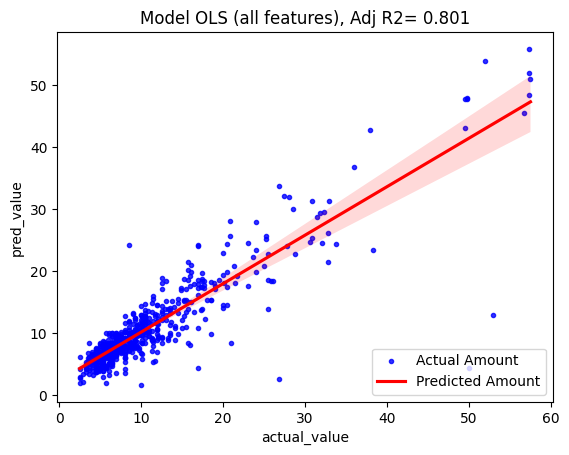

In [159]:
# Building model
model_LR,summary1,res1,errors1=build_viz_model(train_x1, train_y1, test_x1, test_y1,title='Model OLS (all features)')

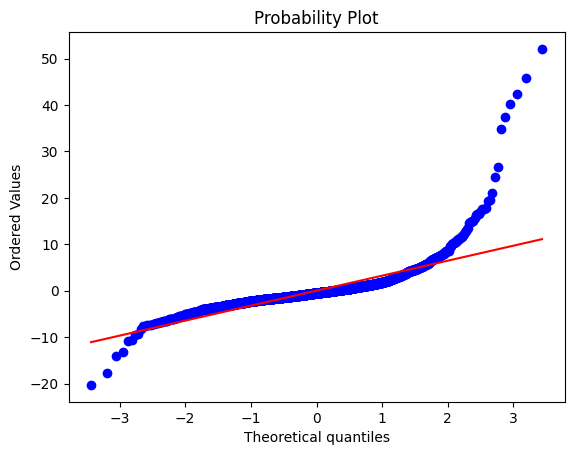


Number of records is greater than the number of features.


Null hypothesis is rejected. The 'index' data is NOT normal.
Null hypothesis is rejected. The 'pass' data is NOT normal.
Null hypothesis is rejected. The 'distance' data is NOT normal.
Null hypothesis is rejected. The 'pkp_year' data is NOT normal.
Null hypothesis is rejected. The 'pkp_month' data is NOT normal.
Null hypothesis is rejected. The 'pkp_day' data is NOT normal.
Null hypothesis is rejected. The 'pkp_hour' data is NOT normal.
Null hypothesis is rejected. The 'pkp_minute' data is NOT normal.


Null hypothesis is rejected. The error data is NOT normal.


The data is homoscedastic, i.e the variance in the errors is NOT dependent on the feature.
The mean of the training errors is zero.


The correlation between features :


,index,pass,distance,pkp_year,pkp_month,pkp_day,pkp_hour,pkp_minute
index,1.000000,0.033977,-0.005338,-0.023353,0.050254,-0.001156,0.006266,-0.020707
pass,0.033977,1.000000,0.027904,0.033151,-0.000440,0.014772,0.032515,-0.021641
distance,-0.005338,0.027904,1.000000,0.041555,0.007280,-0.006183,-0.033263,-0.011699
pkp_year,-0.023353,0.033151,0.041555,1.000000,-0.121328,-0.028889,0.009271,-0.000070
pkp_month,0.050254,-0.000440,0.007280,-0.121328,1.000000,-0.033454,-0.000290,-0.004258
pkp_day,-0.001156,0.014772,-0.006183,-0.028889,-0.033454,1.000000,-0.012993,0.023518
pkp_hour,0.006266,0.032515,-0.033263,0.009271,-0.000290,-0.012993,1.000000,0.016737
pkp_minute,-0.020707,-0.021641,-0.011699,-0.000070,-0.004258,0.023518,0.016737,1.000000


In [151]:
# Cheking assumptions
validations=validating_LR(df_scaled.drop(target,axis=1),num,model_LR)

for i in validations :
    if i is validations[-1] :
      display(i)
    else :
      print(i)


There are 2329 records in the training set. 
There are 583 records in the testing set.
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     2459.
Date:                Fri, 24 Nov 2023   Prob (F-statistic):               0.00
Time:                        07:14:16   Log-Likelihood:                -6404.3
No. Observations:                2329   AIC:                         1.282e+04
Df Residuals:                    2324   BIC:                         1.285e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

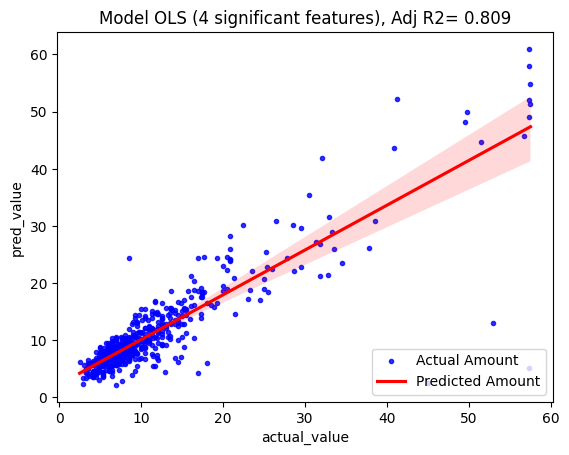

In [160]:
# Building another OLS model with top 4 significant features
cols2=df_features['feature_name'][:4].values

train_x2,test_x2,train_y2,test_y2=split_data(df_scaled,cols=cols2,target=target,test_size=0.2)

model2_LR,summary2,res2,errors2=build_viz_model(train_x2, train_y2, test_x2, test_y2,title='Model OLS (4 significant features)')

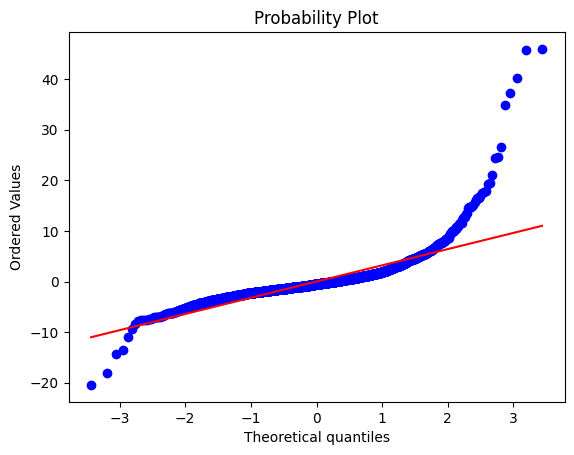


Number of records is greater than the number of features.


Null hypothesis is rejected. The 'distance' data is NOT normal.
Null hypothesis is rejected. The 'pkp_year' data is NOT normal.
Null hypothesis is rejected. The 'pkp_hour' data is NOT normal.
Null hypothesis is rejected. The 'pkp_month' data is NOT normal.


Null hypothesis is rejected. The error data is NOT normal.


The data is heteroscedastic, i.e the variance in the errors is dependent on the feature.
The mean of the training errors is zero.


The correlation between features :


,distance,pkp_year,pkp_hour,pkp_month
distance,1.000000,0.041555,-0.033263,0.007280
pkp_year,0.041555,1.000000,0.009271,-0.121328
pkp_hour,-0.033263,0.009271,1.000000,-0.000290
pkp_month,0.007280,-0.121328,-0.000290,1.000000


In [162]:
# Validations for model 2
validations2=validating_LR(df_scaled.drop(target,axis=1),cols2,model2_LR)

for i in validations2 :
    if i is validations2[-1] :
      display(i)
    else :
      print(i)

## Evaluation :

In [163]:
# COMPARING DIFFERENT MODELS :
sse,mse,rmse,adj_r2=[],[],[],[]
models=['Lin Reg (all features)','Lin Reg (4 features)']
headers=['MODELS','SSE','MSE','RMSE','ADJ_R2']
l1=[errors1,errors2]

for i in l1 :
    sse.append(i['SSE'])
    mse.append(i['MSE'])
    rmse.append(i['RMSE'])
    adj_r2.append(i['Adj R2'])

table=list(zip(models,sse,mse,rmse,adj_r2))
print(tabulate(table,headers=headers))

MODELS                       SSE     MSE    RMSE    ADJ_R2
----------------------  --------  ------  ------  --------
Lin Reg (all features)   9119.98  15.643   3.955   0.8008
Lin Reg (4 features)    10888.8   18.677   4.322   0.80855


- The linear regression model with all features is a better model as it has lower RMSE value and satisfies more assumptions that the other model.